In [1]:
import os
import glob
from pathlib import Path
import json
import numpy as np
import nussl
import torch
from nussl.datasets import transforms as nussl_tfm
from common import utils, argbind
import matplotlib.pyplot as plt
from nussl.ml.networks.modules import AmplitudeToDB, BatchNorm, RecurrentStack, Embedding
from nussl.separation.base import MaskSeparationBase, DeepMixin, SeparationException
from torch import nn
# from torch.nn.utils import weight_norm
from ignite.engine import Events, Engine, EventEnum
from nussl.ml import SeparationModel
from nussl.ml.networks.modules import (
    Embedding, DualPath, DualPathBlock, STFT, Concatenate, 
    LearnedFilterBank, AmplitudeToDB, RecurrentStack,
    MelProjection, BatchNorm, InstanceNorm, ShiftAndScale
)
from torch import optim
import sys

sys.path.append("../../")
from setup_al3625 import *

In [2]:
utils.logger()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

name = os.getcwd().split("/")[-1]

eval_folder = os.path.join("../../eval_results", name)
output_folder = os.path.join("../../trained_models", name)
results_folder = os.path.join(eval_folder, name)
separator_folder = os.path.join("../../trained_models", name, "separator")
audio_folder = os.path.join("../../output_audio", name)

saved_model_best = os.path.join(output_folder, "checkpoints/best.model.pth")
saved_model_new = os.path.join(output_folder, "checkpoints/latest.model.pth")
saved_opt_best = os.path.join(output_folder, "checkpoints/best.optimizer.pth")
saved_opt_new = os.path.join(output_folder, "checkpoints/latest.optimizer.pth")
saved_separator = os.path.join(separator_folder, "separator.model.pth")

if not os.path.exists(output_folder):
    os.mkdir(output_folder)
if not os.path.exists(eval_folder):
    os.mkdir(eval_folder)
if not os.path.exists(results_folder):
    os.mkdir(results_folder)
if not os.path.exists(separator_folder):
    os.mkdir(separator_folder)
if not os.path.exists(audio_folder):
    os.mkdir(audio_folder)

In [3]:
EPOCHS = 100
BATCH_SIZE = 8 
LEARNING_RATE = 1e-3 

stft_params = nussl.STFTParams(window_length=512, hop_length=128)
nf = stft_params.window_length // 2 + 1

keys = ["posterior"]
post_depth=False
use_corpus=False
train_data, val_data, test_data = get_data("../../", keys=keys, post_depth=post_depth, use_corpus=use_corpus)


In [4]:
class PosteriorModel(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, num_sources, 
                activation='sigmoid'):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)

        self.post_normalization = BatchNorm(41)
        self.concatenate = Concatenate(dim = -2)
        self.recurrent_stack = RecurrentStack(
            41 + num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout, 'lstm'
        )

        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   num_sources, activation, 
                                   num_audio_channels)
        
    def forward(self, mix_magnitude, posterior):
        mix_magnitude_db = self.amplitude_to_db(mix_magnitude)
        mix_magnitude_norm = self.input_normalization(mix_magnitude_db)

        combo_data = self.concatenate(mix_magnitude_norm, posterior)
        stack_data = self.recurrent_stack(combo_data)
        
        mask = self.embedding(stack_data)
        estimates = mix_magnitude.unsqueeze(-1) * mask
        output = {
            'mask': mask,
            'estimates': estimates
        }
        return output
        
    @staticmethod
    @argbind.bind_to_parser()
    def build(num_features, num_audio_channels, hidden_size, 
              num_layers, bidirectional, dropout, num_sources,
              activation='sigmoid'):
        nussl.ml.register_module(PosteriorModel)
        modules = {
            'model': {
                'class': 'PosteriorModel',
                'args': {
                    'num_features': num_features,
                    'num_audio_channels': num_audio_channels,
                    'hidden_size': hidden_size,
                    'num_layers': num_layers,
                    'bidirectional': bidirectional,
                    'dropout': dropout,
                    'num_sources': num_sources,
                    'activation': activation
                }
            }
        }
        connections = [
            ['model', ['mix_magnitude', 'posterior']]
        ]
        for key in ['mask', 'estimates']:
            modules[key] = {'class': 'Alias'}
            connections.append([key, [f'model:{key}']])
        output = ['estimates', 'mask',]
        config = {
            'name': 'PosteriorModel',
            'modules': modules,
            'connections': connections,
            'output': output
        }
        return nussl.ml.SeparationModel(config)

In [5]:
model = PosteriorModel.build(num_features=nf,
                            num_audio_channels=1, 
                            hidden_size=512,
                            num_layers=3,
                            bidirectional=True, 
                            dropout=0.3, 
                            num_sources=1,
                            activation='sigmoid')

if os.path.exists(saved_model_new):
    model_checkpoint = torch.load(saved_model_new)
    model = SeparationModel(model_checkpoint["config"]) 
    model.load_state_dict(model_checkpoint["state_dict"])
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    optimizer_checkpoint =  torch.load(saved_opt_new)
    optimizer.load_state_dict(optimizer_checkpoint)

else:
    model = PosteriorModel.build(num_features=nf,
                             num_audio_channels=1, 
                             hidden_size=512,
                             num_layers=3,
                             bidirectional=True, 
                             dropout=0.3, 
                             num_sources=1, 
                             activation='sigmoid')
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [6]:
loss_fn = nussl.ml.train.loss.L1Loss()
def train_step(engine, batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    loss.backward() # backwards + gradient step
    optimizer.step()
    loss_vals = {
        'L1Loss': loss.item(),
        'loss': loss.item()
    }
    return loss_vals

def val_step(engine, batch):
    with torch.no_grad():
        output = model(data=batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    loss_vals = {
        'L1Loss': loss.item(),
        'loss': loss.item()
    }
    return loss_vals

In [7]:
train_dataloader = torch.utils.data.DataLoader(
    train_data, num_workers=4, batch_size=BATCH_SIZE)
val_dataloader = torch.utils.data.DataLoader(
    val_data, num_workers=4, batch_size=BATCH_SIZE) 

In [8]:
trainer, validator = modified_create_train_and_validation_engines(
    train_step, val_step, device=DEVICE
)
nussl.ml.train.add_stdout_handler(trainer, validator)
nussl.ml.train.add_validate_and_checkpoint(output_folder, model,
    optimizer, train_data, trainer, val_dataloader, validator)
nussl.ml.train.add_progress_bar_handler(trainer, validator)

if os.path.exists(saved_model_new):
    trainer.load_state_dict(model_checkpoint["metadata"]["trainer.state_dict"])
    trainer.state.epoch_history = model_checkpoint["metadata"]["trainer.state.epoch_history"]

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training(engine):
    plt.plot(trainer.state.iter_history['loss'])
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.show()

    data = engine.state.epoch_history
    plt.figure(figsize=(5, 4))
    plt.subplot(111)
    plt.plot(data['validation/L1Loss'], label='val')
    plt.plot(data['train/L1Loss'], label='train')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.tight_layout()
    plt.show()

trainer.run(
    train_dataloader,
    max_epochs=EPOCHS
)

Testing

In [9]:
separator = DeepMaskEstimationPosterior(
    nussl.AudioSignal(), None, model_path=saved_model_best,
    device=DEVICE
)
separator.model.save(saved_separator)

/home/lankaraniamir/miniconda3/envs/sep/lib/python3.8/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/home/lankaraniamir/miniconda3/envs/sep/lib/python3.8/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


'../../trained_models/audio_post_no_norm/separator/separator.model.pth'

In [10]:
for i, item in enumerate(test_data):
    separator.audio_signal = item['mix']
    separator.posterior = item['posterior']
    item['posterior'].to(DEVICE)
    estimates = separator()

    source_keys = list(item['sources'].keys())
    estimates = {
        'vocals': estimates[0],
        'non-vocals': item['mix'] - estimates[0]
    }

    sources = [item['sources'][k] for k in source_keys]
    estimates = [estimates[k] for k in source_keys]

    evaluator = nussl.evaluation.BSSEvalScale(
        sources, estimates, source_labels=source_keys
    )
    scores = evaluator.evaluate()
    output_file = os.path.join(eval_folder, f"{i}.json")
    with open(output_file, 'w') as f:
        json.dump(scores, f, indent=4)
    if i % 5 == 0:
        print([i], output_file) 

    song_dir = os.path.join(audio_folder, str(i))
    if not os.path.exists(song_dir):
        os.mkdir(song_dir)
    estimates[0].write_audio_to_file(os.path.join(song_dir, "Predicted Vocals.wav"))
    estimates[1].write_audio_to_file(os.path.join(song_dir, "Predicted Non-Vocals.wav"))
    sources[0].write_audio_to_file(os.path.join(song_dir, "True Vocals.wav"))
    sources[1].write_audio_to_file(os.path.join(song_dir, "True Non-Vocals.wav"))
    item["mix"].write_audio_to_file(os.path.join(song_dir, "Full Mix.wav"))
    print(i)

[0] ../../eval_results/audio_post_no_norm/0.json
0
1
2
3
4
[5] ../../eval_results/audio_post_no_norm/5.json
5
6
7
8
9
[10] ../../eval_results/audio_post_no_norm/10.json
10
11
12
13
14
[15] ../../eval_results/audio_post_no_norm/15.json
15
16
17
18
19
[20] ../../eval_results/audio_post_no_norm/20.json
20
21
22
23
24
[25] ../../eval_results/audio_post_no_norm/25.json
25
26
27
28
29
[30] ../../eval_results/audio_post_no_norm/30.json
30
31
32
33
34
[35] ../../eval_results/audio_post_no_norm/35.json
35
36
37
38
39
[40] ../../eval_results/audio_post_no_norm/40.json
40
41
42
43
44


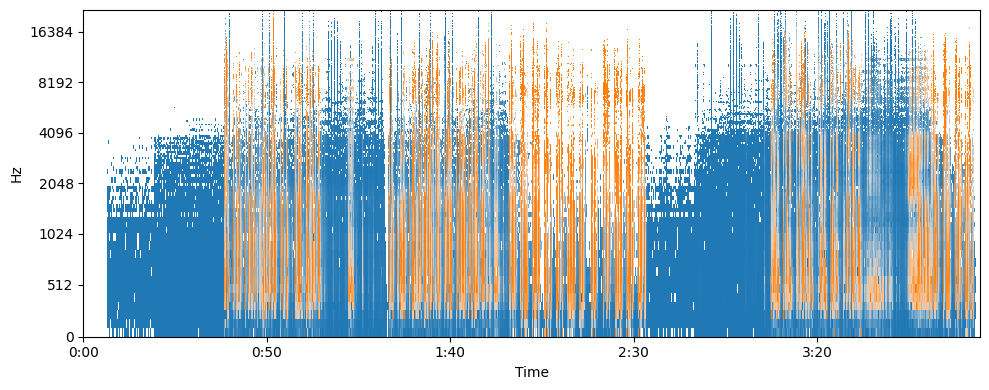

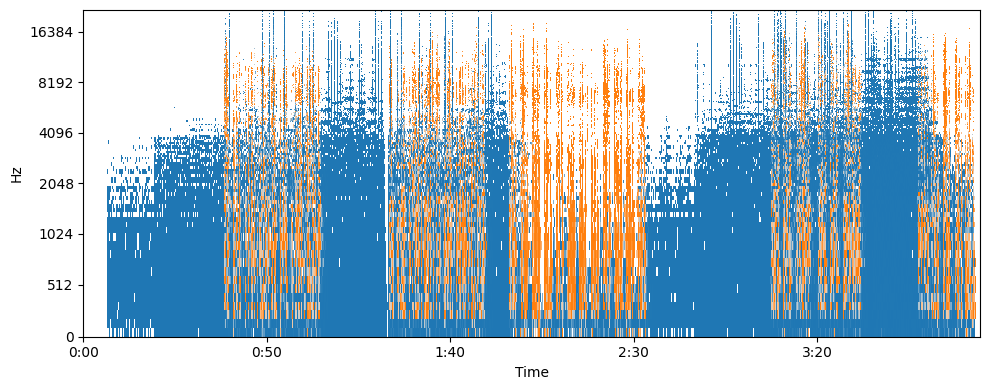

In [12]:
item = test_data[4]
separator.audio_signal = item['mix']
separator.posterior = item['posterior']
estimates = separator()
estimates.append(item['mix'] - estimates[0])
visualize_masks(estimates)


source_keys = list(item['sources'].keys())
sources = [item['sources'][k] for k in source_keys]
visualize_masks(sources)

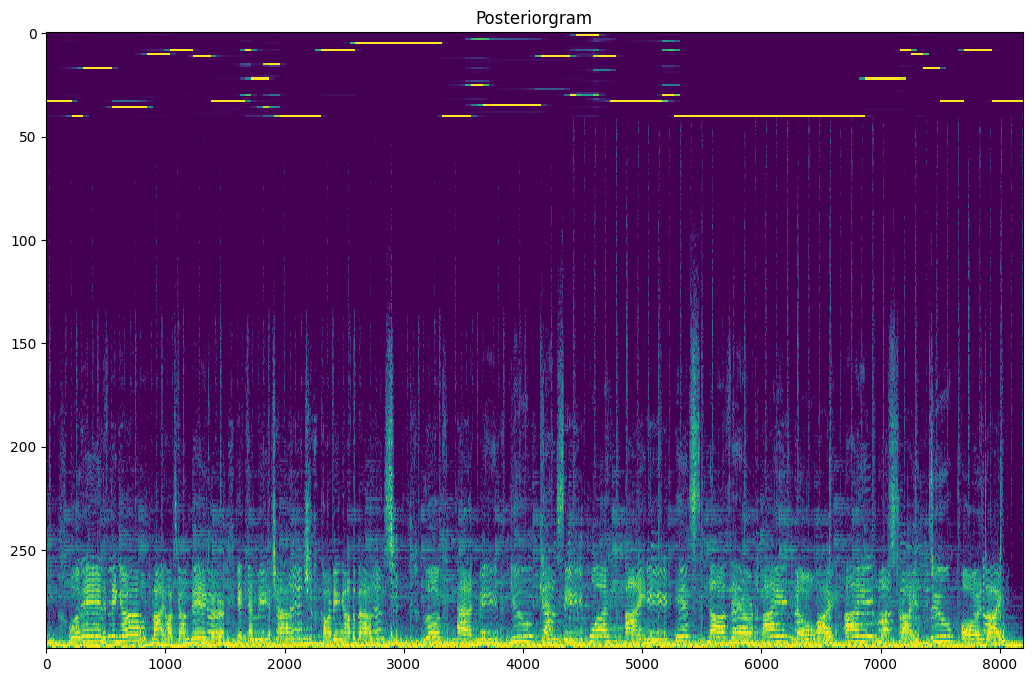

In [ ]:
from sklearn.preprocessing import normalize
from sklearn import preprocessing

item = train_data[2]
amp = AmplitudeToDB()
spectrogram = amp(item['mix_magnitude'])
spectrogram = spectrogram.squeeze(-1).T
pgrams = item['posterior'].squeeze(-1).T
pgrams = np.flipud(pgrams)
spectrogram = np.flipud(spectrogram)
n_s = preprocessing.MinMaxScaler().fit_transform(spectrogram)
n_p = preprocessing.MinMaxScaler().fit_transform(pgrams)
n_s = torch.from_numpy(n_s)
n_p = torch.from_numpy(n_p)

combined = torch.cat((n_p, n_s), dim=0)

plt.title("Spectrogram + Posteriorgram")
plt.imshow(combined, interpolation='nearest', aspect="auto", alpha=1)
# plt.imshow(combined, cmap='gray', interpolation='nearest', aspect="auto", alpha=1)
plt.rcParams['figure.figsize'] = [14*.9, 10*.8]
plt.show()

In [ ]:
embed_audio(estimates)

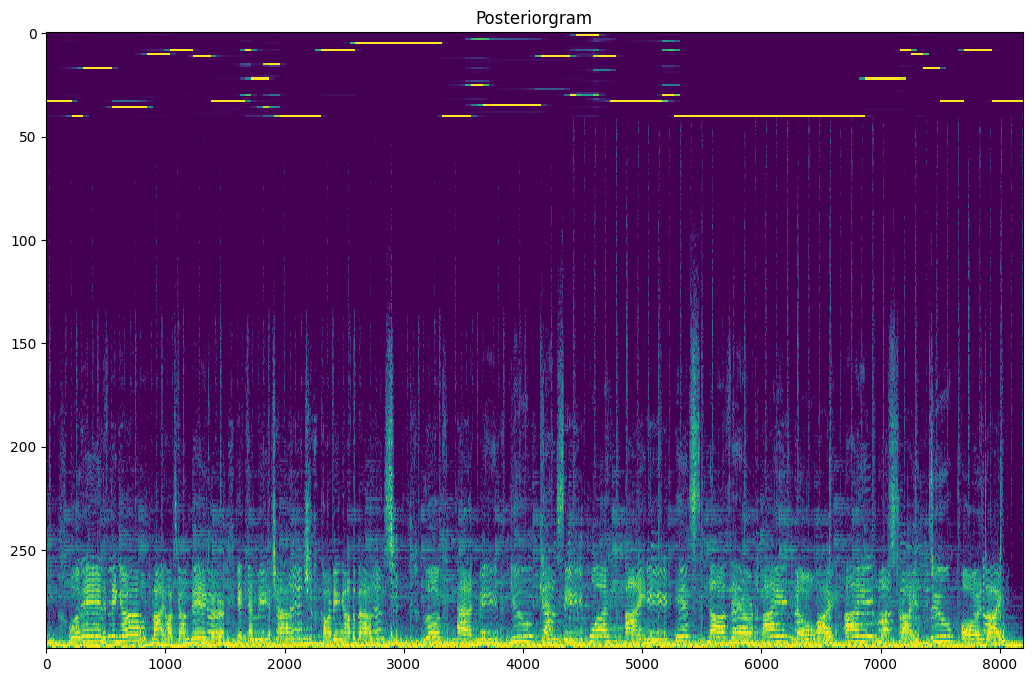

In [ ]:
from sklearn.preprocessing import normalize
from sklearn import preprocessing

item = train_data[2]
amp = AmplitudeToDB()
spectrogram = amp(item['mix_magnitude'])
spectrogram = spectrogram.squeeze(-1).T
pgrams = item['posterior'].squeeze(-1).T
pgrams = np.flipud(pgrams)
spectrogram = np.flipud(spectrogram)
n_s = preprocessing.MinMaxScaler().fit_transform(spectrogram)
n_p = preprocessing.MinMaxScaler().fit_transform(pgrams)
n_s = torch.from_numpy(n_s)
n_p = torch.from_numpy(n_p)

combined = torch.cat((n_p, n_s), dim=0)

plt.title("Posteriorgram")
plt.imshow(combined, interpolation='nearest', aspect="auto", alpha=1)
# plt.imshow(combined, cmap='gray', interpolation='nearest', aspect="auto", alpha=1)
plt.rcParams['figure.figsize'] = [14*.9, 10*.8]
plt.show()